### Assignment 2: Bias in Data
## Analyzing Wikipedia articles on political figures from different countries.
###### Vishnu Nandakumar


The main objective of this notebook is to provide a detailed walkthrough of the steps involved in analysing quality of the Wikipedia articles on political figures from various countries. The data involved in the analysis are obtained from two sources:
- Politicians by Country from the English-language Wikipedia dataset: [Source: Figshare](https://figshare.com/articles/Untitled_Item/5513449) 
- 2018 World Populataion Data Sheet by the Population Reference Bureau: [Source: Dropbox](https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0)

The data quality is assesed using **ORES (Objective Revision Evaluation Service)**, which is a web service and API that provides machine learning as a service for Wikimedia projects maintained by the Scoring Platform team.

The notebook is organized into the following sections:
- Getting Article and Population data
- Getting Article quality estimates using ORES
- Creating the analytic dataset
- Analysis and Results 

In [1]:
# Loading the necessary packages
import json
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

Defining generic functions to read the datasets as well as to access the ORES service.

In [2]:
def get_data(file):
    """
    Function to retrieve the specified file as a dataframe.
    Expects the target file to be a .csv file.
    Args:
        file(str): Path of the target file
    Returns:
        df(pandas.Dataframe)
    Raises:
        FileNotFoundError: If file doesn't exist.
    """
    try:
        df = pd.read_csv(file,thousands=',')
        return df
    except FileNotFoundError:
        raise FileNotFoundError("The file {} does not exist".format(file))
        
HEADERS = {'User-Agent' : 'https://github.com/vivanvish', 'From' : 'vishnn@uw.edu'}

def get_ores_data(revision_ids):
    """
    Function to retrieve the quality scores from ORES API.
    Args:
        revision_ids (int): The revision id of the articles,
        headers(dict): Request headers.
    Returns:
        rev_score_arr(list:dict) : List of dictionaries with revision_id:score pairs.
        error_revs(list:int) : List of revision ids for which we didnt get the score.
    """
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params), headers=HEADERS)
    response = api_call.json()
    
    # Stripping out the scores in the predictions.
    rev_score_arr = []
    error_revs = []
    for rev_id in revision_ids:
        try:
            score = response['enwiki']["scores"][str(rev_id)]["wp10"]["score"]["prediction"]
            rev_score_arr.append({'rev_id':rev_id,
                                  'score':score})
        except:
            # Storing the rev_ids for which we couldn't get any score.
            error_revs.append(rev_id)
    return rev_score_arr, error_revs


### Section 1: Getting Article and Population data
### Population Data

The population data used here is obtained from the Population Reference Bureau's 2018 estimates. In order to ensure full reproducibility the data has been saved to Dropbox and can be downloaded freely. The link can be found in project description given above and also in the readme. For convenience I have downloaded and stored it in the data folder under the name `WPDS_2018_data.csv`.

In [3]:
population_df = get_data('data/WPDS_2018_data.csv')
# An initial look at the data
population_df.head()

,Geography,Population mid-2018 (millions)
0,AFRICA,1284.0
1,Algeria,42.7
2,Egypt,97.0
3,Libya,6.5
4,Morocco,35.2


In [52]:
population_df.shape

(207, 2)

There are 207 individual locations in the dataset. The individual countries are listed under their a parent geographical locations such as their respective continents etc. Let's check for the parent level geographical locations. **We can filter them by searching for location names in all caps.**

In [46]:
population_df[population_df["Geography"].str.isupper()]

,Geography,Population mid-2018 (millions)
0,AFRICA,1284.0
56,NORTHERN AMERICA,365.0
59,LATIN AMERICA AND THE CARIBBEAN,649.0
95,ASIA,4536.0
144,EUROPE,746.0
189,OCEANIA,41.0


In [67]:
# Saving them for further use.
aggregate_locs = population_df[population_df["Geography"].str.isupper()]["Geography"].tolist()

There are 6 parent level locations. 

Let's check for any NaNs and unusual values.

In [45]:
population_df[population_df.isnull().any(axis=1)]

,Geography,Population mid-2018 (millions)


Looks like no NaNs, which is good. Checking for unsual values by looking at the max and min values.  

In [47]:
population_df["Population mid-2018 (millions)"].min(), population_df["Population mid-2018 (millions)"].max()

(0.01, 4536.0)

Seems like there are no unusual values that are negative or zeroes.

### Wikipedia Article Data

The article dataset is basically the metadata of articles on Politicians by country published on Wikipedia English. However, the time span of the data is not clear. The data was published on `28.10.2017`, so for the purpose of the analysis we can assume that as the upper limit on the time span. The link is provided in the description above as well as in the readme. The data is also stored locally as `page_data.csv` in the `data` folder.

In [115]:
article_df = get_data('data/page_data.csv')
article_df.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [116]:
article_df["country"].unique().shape

(219,)

Despite lacking the aggregate locations, there seems to be more locations in this dataset than that is there in the Population dataset. Looking a bit deeper to find the extra locations, so that we can be careful while creating the final analytical dataset.

In [117]:
population_locs = population_df["Geography"].unique().tolist()
article_locs = article_df["country"].unique().tolist()
# Finding set of locations present in article locations and not in population locations.
# Also ignoring the aggregate locations since they are not relevant here.
set(article_locs) - set(population_locs) - set(aggregate_locs)

{'Abkhazia',
 'Cape Colony',
 'Carniolan',
 'Chechen',
 'Congo, Dem. Rep. of',
 'Cook Island',
 'Czech Republic',
 'Dagestani',
 'East Timorese',
 'Faroese',
 'French Guiana',
 'Greenlandic',
 'Guadeloupe',
 'Guernsey',
 'Hondura',
 'Incan',
 'Ivorian',
 'Jersey',
 'Martinique',
 'Montserratian',
 'Niuean',
 'Omani',
 'Ossetian',
 'Palauan',
 'Palestinian Territory',
 'Pitcairn Islands',
 'Rhodesian',
 'Rojava',
 'Saint Kitts and Nevis',
 'Saint Lucian',
 'Saint Vincent and the Grenadines',
 'Salvadoran',
 'Samoan',
 'Somaliland',
 'South African Republic',
 'South Korean',
 'South Ossetian',
 'Swaziland',
 'Tokelauan'}

I checked the individual locations in this list and several of them could be corrected easily by mapping to the respective country names. However there are several others, such as **Abkhazia, South Ossetia** etc, that are currently in conflict and thus their status is not certain. And several others that are considered as overseas territories and independent governing regions. I have left those locations untouched to avoid making any untoward assumptions. So below you can see the new names that will be applied to the some of the locations in the article dataset.

In [118]:
# correcting the names to match those in the population dataset.
corrections = {
    'Cape Colony': 'South Africa',
    'Congo, Dem. Rep. of':'Congo, Dem. Rep.',
    'Czech Republic':'Czechia',
    'East Timorese':'Timor-Leste',
    'South Korean' : 'Korea, South',
    'Swaziland': 'eSwatini',
    'Samoan':'Samoa',
    'South African Republic':'South Africa',
    'Saint Lucian':'Saint Lucia',
    'Guadeloupe':'France',
    'Hondura':'Honduras',
    'Ivorian':"Cote d'Ivoire",
    'Omani':'Oman',
    'Palauan':'Palau',
    'Saint Kitts and Nevis':'St. Kitts-Nevis',
    'Saint Vincent and the Grenadines':'St. Vincent and the Grenadines',
    'Salvadoran':'El Salvador',
    'Rhodesian':'Zimbabwe'
}
# Mapping to new names
article_df["country"] = article_df["country"].map(corrections).fillna(article_df['country'])
# Saving the new updated data
article_df.to_csv('data/page_data_v1.csv',index=False)

### Section 2: Getting the article scores using ORES.

As mentioned above ORES is a machine learning service that returns the quality of an article in the form of the following levels from highest to lowest:
- FA - Featured article
- GA - Good article
- B - B-class article
- C - C-class article
- Start - Start-class article
- Stub - Stub-class article

Here the classes FA and GA are assigned to articles that are deemed high quality.
Inorder to retrieve the scores from ORES, we need to provide a revision ID, which is the third column in page_data.csv  and the machine learning model, which is `wp10`.

According to the API docs, it can handle 150 calls, so we need to send the requests in chunks to avoid hitting the rate limitter. 

In [136]:
## Reading in the updated version of article data 'page_data_v1.csv'
article_df = get_data('data/page_data_v1.csv')

## The number of rows ~47000, so dividing the data into 500 chunks of approx. 90 rows.
revision_score_arr = []
revs_with_error = []
for i, chunk in enumerate(np.array_split(article_df, 500)):
    if (i+1)%100 == 0:
        print("Chunk: {}".format(i))
    rev_ids = chunk['rev_id'].tolist()
    # Getting the scores and storing the results in arrays.
    rev_score_chunk, error_revs = get_ores_data(rev_ids)
    revision_score_arr.extend(rev_score_chunk)
    revs_with_error.extend(error_revs)
    

Chunk: 99
Chunk: 199
Chunk: 299
Chunk: 399
Chunk: 499


In [142]:
len(revision_score_arr), len(revs_with_error)

(47092, 105)

We got the score for almost all articles, except 105, which I assume should be okay.

We now need to merge this result with the article data and then combine that with the population data to get the final analytical dataset. 

In [147]:
# Creating dataframe containing revision id and scores.
revision_score_df = pd.DataFrame(revision_score_arr)
# Combining this with the article data.
article_df = article_df.merge(revision_score_df, on='rev_id')
article_df.head(5)

,page,country,rev_id,score
0,Bir I of Kanem,Chad,355319463,Stub
1,Template:Zimbabwe-politician-stub,Zimbabwe,391862046,Stub
2,Template:Uganda-politician-stub,Uganda,391862070,Stub
3,Template:Namibia-politician-stub,Namibia,391862409,Stub
4,Template:Nigeria-politician-stub,Nigeria,391862819,Stub


In [148]:
# Saving the data.
article_df.to_csv('data/page_data_with_scores.csv', index=False)

Now we need to combine this data with the population data. Before doing that we need to ensure that the dataframe are consistently named.

In [149]:
population_df.head()

,Geography,Population mid-2018 (millions)
0,AFRICA,1284.0
1,Algeria,42.7
2,Egypt,97.0
3,Libya,6.5
4,Morocco,35.2


In [150]:
# Uncomment these lines if you want to restart from this point.
# article_df = get_data('data/page_data_with_scores.csv')
# population_df = get_data('data/WPDS_2018_data.csv')

population_df = population_df.rename(columns={'Geography':'country', 'Population mid-2018 (millions)':'population'})
article_df = article_df.rename(columns={'page':'article_name', 'rev_id':'revision_id', 'score':'article_quality'})

In [151]:
# Merging the two dataframes to get the final analytical data.
final_data = article_df.merge(population_df, on='country')

In [153]:
final_data.head(5)

,article_name,country,revision_id,article_quality,population
0,Bir I of Kanem,Chad,355319463,Stub,15.4
1,Abdullah II of Kanem,Chad,498683267,Stub,15.4
2,Salmama II of Kanem,Chad,565745353,Stub,15.4
3,Kuri I of Kanem,Chad,565745365,Stub,15.4
4,Mohammed I of Kanem,Chad,565745375,Stub,15.4


In [154]:
final_data.shape

(46371, 5)

The final dataset looks fine. We lost a couple of hundreds of articles because we didn't have matching names for several locations in the population dataset. But this should be enough to get a reasonable good result for our analysis. Last step is to save this data to ensure reproducibility.

In [155]:
final_data.to_csv('data/article_quality_with_population.csv', index=False)

### Section 3: Analysis of articles 

The analysis involves processing the final data to find the article per person for each country and also examining the proportion of high quality articles. The steps involved are:
- Finding the number of articles for each country.
- Dividing by the population gives number of articles per person.
- Sort the values in decreasing order for convenience.

Note : Need to ensure that population is in the right scale

In [43]:
# Reading the analytical dataset.
score_with_population_data = get_data('data/article_quality_with_population.csv')
# Converting population to original scale.
score_with_population_data['population'] = score_with_population_data['population']*1000000
# Finding the number of articles by country
articles_by_country = score_with_population_data.groupby(['country','population']).agg('count')['article_name'].reset_index()
# Renaming the column to reflect the value it contains.
articles_by_country = articles_by_country.rename(columns={'article_name':'num_article'})

# Finding the number of articles per person
articles_by_country["article_per_person"] = articles_by_country['num_article'] / articles_by_country['population']
articles_by_country = articles_by_country.sort_values(by='article_per_person', ascending=False)

 Q1. 10 highest-ranked countries in terms of number of politician articles as a proportion of country population


              country  population  num_article  article_per_person
178            Tuvalu     10000.0           55            0.005500
120             Nauru     10000.0           53            0.005300
144        San Marino     30000.0           82            0.002733
130             Palau     20000.0           23            0.001150
113            Monaco     40000.0           40            0.001000
98      Liechtenstein     40000.0           29            0.000725
160   St. Kitts-Nevis     50000.0           32            0.000640
173             Tonga    100000.0           63            0.000630
108  Marshall Islands     60000.0           37            0.000617
73            Iceland    400000.0          206            0.000515


Text(0,0.5,'Proportion')

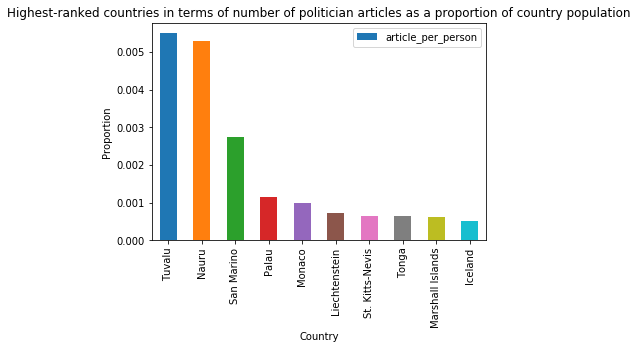

In [57]:
print(articles_by_country.head(10))
ax = articles_by_country.head(10).plot.bar(
    x='country', y='article_per_person', 
    title='Highest-ranked countries in terms of number of politician articles as a proportion of country population')
ax.set_xlabel("Country")
ax.set_ylabel("Proportion")

Q.2 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population.

              country    population  num_article  article_per_person
74              India  1.371300e+09          986        7.190257e-07
75          Indonesia  2.652000e+08          214        8.069382e-07
34              China  1.393800e+09         1135        8.143206e-07
185        Uzbekistan  3.290000e+07           29        8.814590e-07
55           Ethiopia  1.075000e+08          105        9.767442e-07
190            Zambia  1.770000e+07           25        1.412429e-06
87       Korea, North  2.560000e+07           39        1.523437e-06
38   Congo, Dem. Rep.  8.430000e+07          142        1.684460e-06
170          Thailand  6.620000e+07          112        1.691843e-06
13         Bangladesh  1.664000e+08          323        1.941106e-06


Text(112.175,0.5,'Proportion')

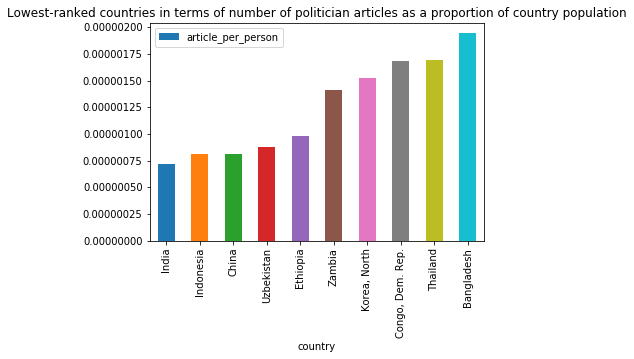

In [58]:
print(articles_by_country.tail(10)[::-1])
articles_by_country.tail(10)[::-1].plot.bar(
    x='country', y='article_per_person',
    title='Lowest-ranked countries in terms of number of politician articles as a proportion of country population')
ax.set_xlabel("Country")
ax.set_ylabel("Proportion")

Q.3 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [46]:
# Finding number of High quality papers and total number of articles by country.
def find_article_counts_by_type(group):
    """
    Function to find the number of articles by type, i.e, high quality or not.
    Args:
        group(pandas.Dataframe):  Dataframe for each country.
    Returns:
        df(pandas.Dataframe): Dataframe with counts by article type.
    """
    high_quality_articles = group.query('article_quality == "FA" or article_quality == "GA"')
    return pd.DataFrame([{'hq_article_counts':high_quality_articles.shape[0],
                          'total_article_counts':group.shape[0]}])
    
article_type_by_country = score_with_population_data.groupby(
    'country').apply(find_article_counts_by_type).reset_index(level=1, drop=True)
article_type_by_country.head(5)

,hq_article_counts,total_article_counts
country,,
Afghanistan,10,326
Albania,4,460
Algeria,2,119
Andorra,0,34
Angola,0,110


In [47]:
# Finding proportion of hq articles and sorting them.
article_type_by_country['proportion_hq_articles'] = (article_type_by_country['hq_article_counts'] / 
                                                     article_type_by_country['total_article_counts'])
article_type_by_country.sort_values(by='proportion_hq_articles', ascending=False, inplace=True)
# Dropping all locations that hasn't published any hq articles so far.
article_type_by_country_hq = article_type_by_country.query('proportion_hq_articles != 0')

In [48]:
article_type_by_country_hq.head(10)

,hq_article_counts,total_article_counts,proportion_hq_articles
country,,,
"Korea, North",7,39,0.179487
Saudi Arabia,16,119,0.134454
Central African Republic,8,68,0.117647
Romania,40,348,0.114943
Mauritania,5,52,0.096154
Tuvalu,5,55,0.090909
Bhutan,3,33,0.090909
Dominica,1,12,0.083333
United States,82,1092,0.075092


Text(0,0.5,'Proportion')

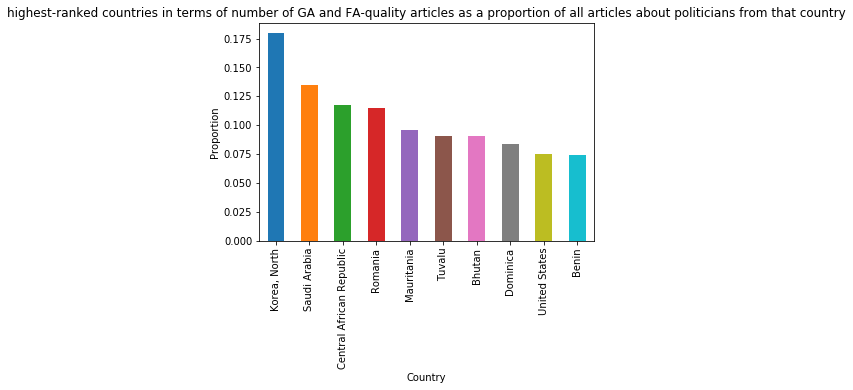

In [59]:
ax = article_type_by_country_hq['proportion_hq_articles'].head(10).plot.bar(
    title='highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country')
ax.set_xlabel("Country")
ax.set_ylabel("Proportion")

Q.4 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [50]:
article_type_by_country_hq.tail(10)[::-1]

,hq_article_counts,total_article_counts,proportion_hq_articles
country,,,
Tanzania,1,408,0.002451
Peru,1,354,0.002825
Czechia,1,254,0.003937
Lithuania,1,248,0.004032
Nigeria,3,682,0.004399
Morocco,1,208,0.004808
Fiji,1,199,0.005025
Bolivia,1,187,0.005348
Brazil,3,551,0.005445


Text(219.542,0.5,'Proportion')

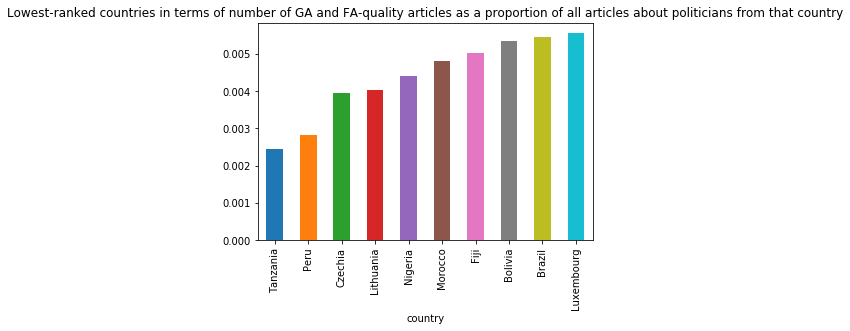

In [60]:
article_type_by_country_hq['proportion_hq_articles'].tail(10)[::-1].plot.bar(
    title='Lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country')
ax.set_xlabel("Country")
ax.set_ylabel("Proportion")

These are the countries for which atleast one article has been classified as a high quality article. There are several countries for which there are no high quality articles at all. Lets see what are those countries.

In [54]:
article_type_by_country_nohq = article_type_by_country.query('proportion_hq_articles == 0')
article_type_by_country_nohq.index.values

array(['Antigua and Barbuda', 'Angola', 'Zambia', 'Andorra', 'Belgium',
       'Cameroon', 'Timor-Leste', 'Bahamas', 'Cape Verde', 'Tunisia',
       'Turkmenistan', 'Uganda', 'Costa Rica', 'Barbados', 'Belize',
       'Comoros', 'Slovakia', 'Switzerland', 'Kazakhstan', 'Monaco',
       'Marshall Islands', 'Malta', 'Mozambique', 'Macedonia', 'Nauru',
       'Nepal', 'Oman', 'Liechtenstein', 'Lesotho', 'Kiribati',
       'Honduras', "Cote d'Ivoire", 'Guyana', 'Finland', 'San Marino',
       'Sao Tome and Principe', 'Federated States of Micronesia',
       'Seychelles', 'Moldova', 'Solomon Islands', 'Djibouti',
       'St. Kitts-Nevis', 'St. Vincent and the Grenadines', 'eSwatini'],
      dtype=object)

Thus we can see several interesting results from the analysis. I have given a more indepth writeup of the results in the Readme of the repository. 